# Model prediction maker

Model setup is as follows: we have dijet asymmetry data prepared, where the asymmetry AJ is defined as the difference between the two jets divided by the sum. Specifically,

$$A_{\mathrm{j}} = \frac{p_{\mathrm{T, 1}} - p_{\mathrm{T, 2}}}{p_{\mathrm{T, 1}} + p_{\mathrm{T, 2}}}$$

We will construct a model to describe the energy loss observed in the dijet asymmetry.  For this model, we consider back-to-back dijets.  Each jet can lose energy, and the lost energy is parameterized as

$$ \Delta p_{\mathrm{T}} / p_{\mathrm{T}} \sim A \times Gaus(1, B)$$

In addition to the energy loss contribution, we have extra "apparent" smearing on the AJ coming from the fact that we have other processes going on in the events (three jets etc).  It is parameterized as a Gaussian smearing on AJ with width C. So there are three total parameters: A, B, and C.

The measurement is done in two bins of centrality.  One in central event, where (A, B, C) are all relevant, and another one in very peripheral event, where only the parameter (C) is relevant.

The goal here in this notebook is to make the inputs needed for Bayesian inference to learn about A, B and C from the provided data

In [1]:
import numpy as np
import os

Folder = 'input/AJExample/'

if not os.path.exists(Folder):
    os.mkdir(Folder)

In [2]:
DataXMin        = 0.000
DataXMax        = 1.000
DataXBin        = 0.050

DataNBin        = int((DataXMax - DataXMin) / DataXBin)

# how many design points do you want to generate?
NDesign         = 40

# What is the upper parameter range (one each for A, B, C)?
# The lower range for each parameter is 0 by construction.
# Hint: start with a large-range guess!  Then we can come back and reduce range
ParameterRanges = [1.0, 1.0, 0.5]

## The "prediction" function

Let's write a function, where we do the required smearing, make a histogram on the final AJ, and return the prediction

In [3]:
def Predict(A, B, C, N = 100000):
    print("Running prediction with", A, B, C)
    
    Hist = np.zeros(DataNBin)
    
    for i in range(N):
        # Jet 1 and jet 2 PT (J1 and J2) after quenching.
        # Assuming initial energy is 100 GeV, and (delta PT / PT) ~ gaus(A, B), calculate the final energy
        # Jet PT = 100 GeV * (?)
        # Note that the initial energy cancels out in AJ
        # Useful function: np.random.normal(1, 2) gives you a random sampling with gaussian mean 1 and sigma 2
        J1 = 100 * (1 - A * np.random.normal(1, B))
        J2 = 100 * (1 - A * np.random.normal(1, B))
        # Calculate AJ from the PTs
        AJ = (J1 - J2) / (J1 + J2)
        # Adding extra gaussian smearing from parameter C
        AJ = AJ + np.random.normal(0, C)
        # AJ is defined to be leading - subleading -> positive!
        AJ = np.abs(AJ)

        # put things into bins
        Bin = int((AJ - DataXMin) / DataXBin)
        if Bin < 0:   # underflow
            Bin = 0
        if Bin >= DataNBin:   # overflow
            continue
            # Bin = DataNBin - 1
        
        Hist[Bin] = Hist[Bin] + 1
        
    return Hist / N

### Test the prediction (cross check for yourself)

In [4]:
# Test predicting one point - to see if the output makes sense or not
# Once you are happy, we move on!
example_prediction = Predict(0.5, 0.25, 0.1)
example_prediction

Running prediction with 0.5 0.25 0.1


array([1.9297e-01, 1.8067e-01, 1.5923e-01, 1.3340e-01, 1.0423e-01,
       7.9260e-02, 5.4720e-02, 3.5980e-02, 2.3620e-02, 1.4830e-02,
       8.9200e-03, 5.1400e-03, 2.8700e-03, 1.8300e-03, 9.6000e-04,
       5.8000e-04, 3.1000e-04, 2.1000e-04, 9.0000e-05, 4.0000e-05])

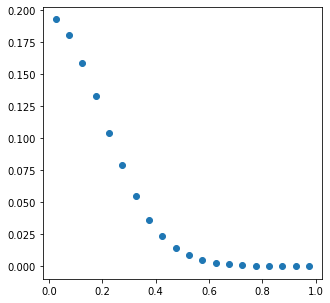

In [5]:
# Alternatively (or in addition), plot the AJ distribution for our single point
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,5))
ax.plot(np.arange(DataXMin, DataXMax, DataXBin) + (DataXBin / 2), example_prediction, marker="o", linestyle="")

## Making the design points

Let's start with a very simple random array :D

In reality we would use something more complicated to distribute the points better, but let's start simple.  Fancy stuff is just a better way to achieve the same purpose.

In [6]:
Design = np.random.rand(NDesign, 3) * ParameterRanges

## Preparing the model predictions

Let's loop over the design points, and call the predict function we just wrote to make a big table!

This step takes a while, like a few minutes.  Please be patient.

In [7]:
# Generate prediction for "central" data
Y1 = [Predict(i[0], i[1], i[2]) for i in Design]
# Generate prediction for "peripheral" data.  Note here A and B are irrelevant.  So we set them to 0
Y2 = [Predict(0, 0, i[2]) for i in Design]

Running prediction with 0.3003991144306818 0.11900364577462141 0.48473190155301804
Running prediction with 0.91519577807384 0.8102652229691304 0.49402312950002947
Running prediction with 0.03055138724603168 0.9339279197894532 0.1739345372291881
Running prediction with 0.03712420030128405 0.25860960697676605 0.025486063085359556
Running prediction with 0.06526919212267857 0.38756896118991213 0.41260706135694514
Running prediction with 0.0049063542810871 0.3554027469054284 0.16989056660071267
Running prediction with 0.6136501989734717 0.6581557646757035 0.35674411604462886
Running prediction with 0.38475328866379876 0.09907440502466847 0.21838678103818748
Running prediction with 0.660066459505741 0.096512699473152 0.08645400436118555
Running prediction with 0.9552742257664444 0.3759291963606566 0.11200053642558694
Running prediction with 0.7821605868194508 0.9499589548821153 0.3183915157087149
Running prediction with 0.8594497814577617 0.10290199784338494 0.08003979101385172
Running pred

## Write everything out

In [8]:
with open(Folder + 'Prediction_Selection1.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# Data Data_Selection1.dat\n')
    f.write('# Design Design.dat\n')
    np.savetxt(f, np.transpose(Y1))

In [9]:
with open(Folder + 'Prediction_Selection2.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# Data Data_Selection2.dat\n')
    f.write('# Design Design.dat\n')
    np.savetxt(f, np.transpose(Y2))

In [10]:
with open(Folder + 'Design.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# Parameter A B C\n')
    np.savetxt(f, Design)

## Making fake data

In [11]:
Truth = [0.50, 0.25, 0.10]

DataY1 = Predict(Truth[0], Truth[1], Truth[2], N = 100000)
DataY2 = Predict(0, 0, Truth[2], N = 100000)

Running prediction with 0.5 0.25 0.1
Running prediction with 0 0 0.1


In [12]:
XMin = np.array(range(0, DataNBin)) * DataXBin
XMax = np.array(range(1, DataNBin + 1)) * DataXBin

Stat = 0.001
Sys = 0.010

Data1 = np.zeros((DataNBin, 7))
Data2 = np.zeros((DataNBin, 7))

Data1[:,0] = XMin
Data1[:,1] = XMax
Data1[:,2] = DataY1
Data1[:,3] = Stat
Data1[:,4] = Stat
Data1[:,5] = Sys
Data1[:,6] = Sys

Data2[:,0] = XMin
Data2[:,1] = XMax
Data2[:,2] = DataY2
Data2[:,3] = Stat
Data2[:,4] = Stat
Data2[:,5] = Sys
Data2[:,6] = Sys

In [13]:
with open(Folder + 'Data_Selection1.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# DOI None\n')
    f.write('# Source None\n')
    f.write('# Experiment JetScape\n')
    f.write('# System PbPb5020\n')
    f.write('# Centrality 0to10\n')
    f.write('# XY AJ DNDAJ\n')
    f.write('# Label xmin xmax y stat,low stat,high sys,low sys,high\n')
    np.savetxt(f, Data1)
    
with open(Folder + 'Data_Selection2.dat', 'w') as f:
    f.write('# Version 1.0\n')
    f.write('# DOI None\n')
    f.write('# Source None\n')
    f.write('# Experiment JetScape\n')
    f.write('# System PbPb5020\n')
    f.write('# Centrality 70to90\n')
    f.write('# XY AJ DNDAJ\n')
    f.write('# Label xmin xmax y stat,low stat,high sys,low sys,high\n')
    np.savetxt(f, Data2)